# **Import some packages**

In [1]:
## Install yfinance
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import pandas as pd
import yfinance as yf
from tqdm import tqdm
from scipy.stats import norm

# Get stock price data from yahoo finance

You can include the tickers you want below in

```python
['0050.TW', '1101.TW', '1216.TW', '2330.TW', '2884.TW', '2603.TW', '00632R.TW']
```
and change the time period

```
start='2021-06-01', end='2022-06-01'
```
Here, we use adjusted closed price of each stock.

In [3]:
underlying = ['0050.TW', '1101.TW', '1216.TW', '2330.TW', '2884.TW', '2603.TW', '00632R.TW']

df = yf.download(underlying, start='2021-06-01', end='2022-06-01')['Adj Close']
df.describe()

[*********************100%***********************]  7 of 7 completed


,0050.TW,00632R.TW,1101.TW,1216.TW,2330.TW,2603.TW,2884.TW
count,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000
mean,137.577143,5.437918,42.250578,65.448116,581.078946,272.691404,25.359716
std,5.726997,0.203077,1.782907,1.743493,30.369600,42.892004,2.629571
min,121.250000,5.030000,36.113262,61.669483,499.394012,180.479736,21.370872
25%,135.050003,5.270000,41.822346,64.455177,566.520142,251.902771,23.053619
50%,138.000000,5.460000,42.397678,65.319710,580.852600,275.170898,25.318756
75%,141.100006,5.590000,43.150036,66.528229,595.335449,290.345764,27.146826
max,152.000000,5.870000,45.761166,69.762238,672.089355,444.586731,32.311119


## Log Return
- We change price data into log return.

In [4]:
# Log return
log_data = np.log(df) - np.log(df.shift(1))
#
log_data.describe()

,0050.TW,00632R.TW,1101.TW,1216.TW,2330.TW,2603.TW,2884.TW
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,-0.000242,-0.000212,-0.000498,-0.000229,-0.000194,0.001157,0.001023
std,0.010591,0.010409,0.009113,0.008745,0.014204,0.044368,0.011266
min,-0.044223,-0.031749,-0.044345,-0.044825,-0.041569,-0.105360,-0.055408
25%,-0.005326,-0.007208,-0.005322,-0.005924,-0.008504,-0.021664,-0.003490
50%,0.000000,0.000000,-0.001006,0.000000,0.000000,0.003497,0.000000
75%,0.005775,0.005487,0.004034,0.005831,0.008396,0.025529,0.005043
max,0.031276,0.030134,0.028821,0.025662,0.046044,0.095310,0.037483


## Simulations for feasible portfolios
We don't consider long-short portfolios,<br>
$$i.e.\quad w_i \geq 0 \quad\forall i$$ and
$$\sum_{i=1}^{N}w_i = 1$$

In [5]:
### Start to derive weight
weight = []
returns = []
risk = []
sharpe = []

num_stock = len(underlying)
num_portfo = 30000
for i in tqdm(range(num_portfo)):
    portfo_weight = np.random.random(num_stock)
    portfo_weight /= np.sum(portfo_weight)
    weight.append(portfo_weight)
    portfo_return = pow(np.dot(portfo_weight, log_data.mean())+1, 244)-1
    portfo_risk = np.sqrt(np.dot( portfo_weight.T, np.dot(log_data.cov()*244, portfo_weight)))
    portfo_sharpe = (portfo_return - 0.01)/portfo_risk
    returns.append(portfo_return)
    risk.append(portfo_risk)
    sharpe.append(portfo_sharpe)

100%|██████████| 30000/30000 [00:53<00:00, 564.12it/s]


In [6]:
portfolio = {"return":returns,"risk":risk,"sharpe":sharpe}  ###把資料都丟到字典裡
for index,stock in enumerate(underlying):
    portfolio[stock[0:-3]+"-weight"] = [each[index] for each in weight]

df_portfolio = pd.DataFrame(portfolio)
df_portfolio.describe()

,return,risk,sharpe,0050-weight,1101-weight,1216-weight,2330-weight,2884-weight,2603-weight,00632R-weight
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.029286,0.137196,0.091301,0.142829,0.141972,0.142743,0.143579,0.142460,0.143036,0.143382
std,0.036895,0.043869,0.289347,0.082239,0.081591,0.081856,0.082120,0.082271,0.081963,0.081942
min,-0.075642,0.032120,-1.855975,0.000004,0.000018,0.000007,0.000009,0.000002,0.000003,0.000010
25%,0.004124,0.104627,-0.051126,0.076567,0.075788,0.076178,0.077355,0.076228,0.076492,0.077843
50%,0.028663,0.133788,0.136608,0.142459,0.141540,0.143247,0.143749,0.142153,0.142988,0.143027
75%,0.053107,0.165384,0.284668,0.202159,0.200790,0.201497,0.202222,0.201452,0.201951,0.202040
max,0.216890,0.436209,1.260226,0.604402,0.595315,0.540089,0.568863,0.558806,0.627047,0.612710


In [7]:
df_best = df_portfolio[df_portfolio["sharpe"].isin([df_portfolio["sharpe"].max()])]

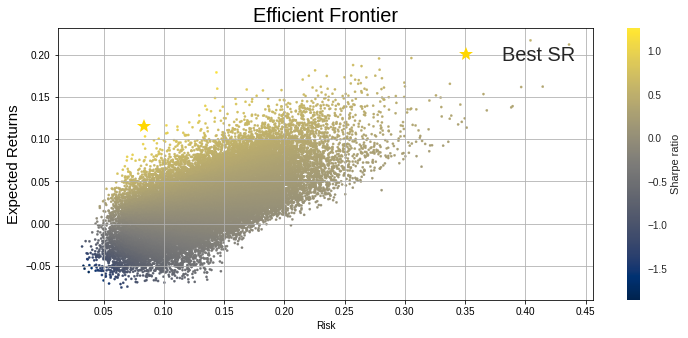

In [8]:
## 散點圖!!
ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(12, 5)
plt.style.use("seaborn")

plt.scatter(x =df_portfolio["risk"],y =df_portfolio["return"],s = 5,c=df_portfolio["sharpe"],cmap = "cividis")
plt.plot(df_best["risk"], df_best["return"],"w*" ,markersize = 15,label ="Best SR", color = 'gold')

plt.xlabel("Risk", fontsize=10)
plt.ylabel('Expected Returns',fontsize=15)
plt.title('Efficient Frontier',fontsize=20)
plt.colorbar(label='Sharpe ratio')
plt.grid(True)
plt.legend(loc='upper right', fontsize=20)
plt.show()

# Mean Variance Optimization

## Solving for efficient frontier

In [9]:
## import necessary packages
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats

In [10]:
#最大夏普率
def indexes(weight,df = log_data):
    portfo_return = pow(np.dot(weight,df.mean())+1,244)-1
    portfo_risk = np.sqrt(np.dot(weight.T, np.dot(df.cov()*252,weight)))
    portfo_sharpe = (portfo_return - 0.01)/portfo_risk
    return np.array([portfo_return, portfo_risk, portfo_sharpe])
def min_sharpe(weight):         ###Object function
    return -indexes(weight,log_data)[2]  ###因為scipy.optimize只有minimize。。。
def min_variance(weight):
    return indexes(weight)[1] ** 2

### scipy求解 非線性規劃
num_stock = len(underlying)
bnds = list((0., 1.) for x in range(num_stock))  ###權重介於0-1之間，有num_stock比權重
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) ### x1+x2+.....+xn = 1
initial_cond = np.array(num_stock * [1. / num_stock])
print("------------------Initial Condition----------------------")
for i,j in enumerate(underlying):
     print(j[0:-3]," = ",initial_cond[i].round(3))
print("---------------------------------------------------------\n\n")
solvs = sco.minimize(min_sharpe , initial_cond, method='SLSQP',  bounds=bnds, constraints=cons)
print(solvs)
print("\n\n------------------Optimal Condition----------------------")
for i,j in enumerate(underlying):
     print(j[0:-4]," = ",solvs['x'].round(3)[i])  #即為最大夏普率的投資组合的權重分配
print(indexes(solvs['x']).round(3))  #獲得最大夏普率的投資组合的收益率、波動率和夏普率
#最小方差的投資组合

------------------Initial Condition----------------------
0050  =  0.143
1101  =  0.143
1216  =  0.143
2330  =  0.143
2884  =  0.143
2603  =  0.143
00632R  =  0.143
---------------------------------------------------------


     fun: -1.5545574001078335
     jac: array([ 1.11815527, -0.25119931,  1.50647897,  0.93495578,  0.95147167,
       -0.25158823, -0.25135241])
 message: 'Optimization terminated successfully'
    nfev: 73
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.00000000e+00, 9.20697407e-02, 9.09968030e-17, 0.00000000e+00,
       3.69054823e-16, 4.46967503e-02, 8.63233509e-01])


------------------Optimal Condition----------------------
005  =  0.0
110  =  0.092
121  =  0.0
233  =  0.0
288  =  0.0
260  =  0.045
00632  =  0.863
[0.25  0.154 1.555]


### Minimal Variance Portfolio

In [11]:
def min_variance(weight):
    return indexes(weight)[1] ** 2

### scipy求解 非線性規劃
num_stock = len(underlying)
bnds = list((0., 1.) for x in range(num_stock))  ###權重介於0-1之間，有num_stock比權重
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) ### x1+x2+.....+xn = 1
initial_cond = np.array(num_stock * [1. / num_stock])
print("------------------Initial Condition----------------------")
for i,j in enumerate(underlying):
     print(j[0:-4]," = ",initial_cond[i].round(3))
print("---------------------------------------------------------\n\n")
solvs2 = sco.minimize(min_variance , initial_cond, method='SLSQP',  bounds=bnds, constraints=cons)
print(solvs2)
print("\n\n------------------Optimal Condition----------------------")
for i,j in enumerate(underlying):
     print(j[0:-3]," = ",solvs2['x'].round(3)[i])  #即為最大夏普率的投資组合的權重分配
print(indexes(solvs2['x']).round(3))  #獲得最大夏普率的投資组合的收益率、波動率和夏普率
#最小方差的投資组合

------------------Initial Condition----------------------
005  =  0.143
110  =  0.143
121  =  0.143
233  =  0.143
288  =  0.143
260  =  0.143
00632  =  0.143
---------------------------------------------------------


     fun: 0.0005950735113132995
     jac: array([0.0012006 , 0.00117093, 0.00125331, 0.00117876, 0.00169411,
       0.00148575, 0.00109469])
 message: 'Optimization terminated successfully'
    nfev: 184
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([0.42094268, 0.4803051 , 0.04425336, 0.02638734, 0.        ,
       0.01284388, 0.01526763])


------------------Optimal Condition----------------------
0050  =  0.421
1101  =  0.48
1216  =  0.044
2330  =  0.026
2884  =  0.0
2603  =  0.013
00632R  =  0.015
[-0.048  0.024 -2.378]


100%|██████████| 50/50 [00:09<00:00,  5.52it/s]


[0.10115596744555409, 0.08277782089748685, 0.06506461563872863, 0.04846017695373295, 0.03431567538696917, 0.026198382811519743, 0.02445390499242665, 0.02447844771798803, 0.02509420873001552, 0.026246008660215345, 0.02787063255856352, 0.029958231144838855, 0.03242053298282385, 0.035178551775522336, 0.038157541162472754, 0.04130085153967262, 0.044564079213176046, 0.04791614724657575, 0.05133234752881257, 0.05479439864166508, 0.05828843594545688, 0.061804715820641176, 0.06533188075375491, 0.06886646687299915, 0.07240959435107287, 0.0760319903984466, 0.0797371543946129, 0.08350805402376721, 0.0873314457527559, 0.0911967624547142, 0.0950943127866664, 0.09901613060560126, 0.10295561762856272, 0.10692311228913078, 0.11108245083576714, 0.11545176972004727, 0.12000109778438982, 0.12470378186223122, 0.12953677274404035, 0.1344800073114285, 0.13951615091064684, 0.14463009584558417, 0.14980892232543594, 0.155041435321991, 0.16031794090537327, 0.16562999540659037, 0.17097031157948936, 0.17633247232

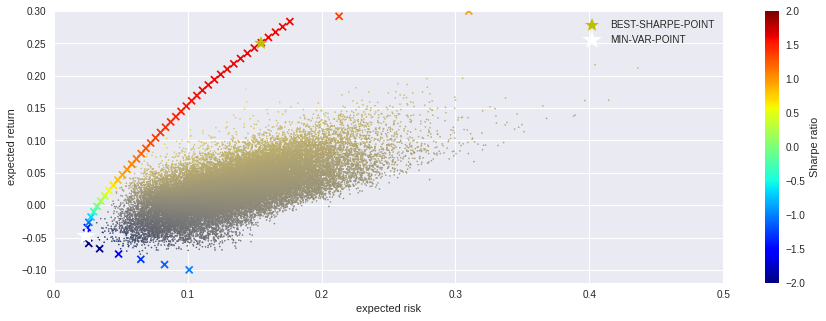

In [13]:
### plot the frontier
def best_port(weight):
    return indexes(weight)[1]
return_interval = np.linspace(-0.1, 0.3, 50)
corr_risk = []
i = 0
for prt in tqdm(return_interval):
    cons = ({'type': 'eq', 'fun': lambda x:  indexes(x)[0] - prt},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(best_port, initial_cond, method='SLSQP',
                       bounds=bnds, constraints=cons)
    corr_risk.append(indexes(res["x"])[1])
print(corr_risk)
corr_risk = np.array(corr_risk)
ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.scatter(df_portfolio["risk"],df_portfolio["return"],s = 1.5,c = df_portfolio["sharpe"],marker = "o",cmap = 'cividis')

plt.scatter(corr_risk, return_interval,c = (return_interval) / corr_risk, marker='x',cmap = 'jet')
plt.plot(indexes(solvs['x'])[1], indexes(solvs['x'])[0],'y*', markersize=15.0, label = "BEST-SHARPE-POINT")
plt.plot(indexes(solvs2["x"])[1], indexes(solvs2["x"])[0], 'w*', markersize=20.0, label = "MIN-VAR-POINT")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

plt.xlim(0.0, 0.5)
plt.ylim(-0.12, 0.3)
plt.grid(True)
plt.xlabel('expected risk')
plt.ylabel('expected return')
plt.clim(-2, 2)
plt.colorbar(label='Sharpe ratio')
plt.legend(fontsize=10)